In [95]:
from netCDF4 import Dataset, MFDataset
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from sklearn.impute import KNNImputer
import time

In [96]:
def create_df(data: Dataset):
    df = pd.DataFrame(columns=['Latitude', 'Longitude', 'xco2', 'Month', 'xco2_quality_flag'])
    df['Longitude'] = np.round(data['longitude'][:] - 0.5) + 0.5
    df['Latitude'] = np.round(data['latitude'][:] - 0.5) + 0.5
    df['xco2'] = data['xco2'][:]
    df = df[data['xco2_quality_flag'][:] == 1]
    df['xco2_mean'] = np.mean(df['xco2'])

    
    df = df.groupby(by=['Latitude', 'Longitude']).median(numeric_only=True).reset_index()

    date = (pd.Timestamp(1970, 1, 1, 0) + pd.to_timedelta(data['time'][0], unit='s')).round(freq='D')
    df['Year'], df['Month'] = date.year, date.month

    return df

In [ ]:
def impute_xco2(df: pd.DataFrame):
    features = ['Latitude', 'Longitude', 'xco2', 'Year', 'Month']
    df[features] = KNNImputer(n_neighbors=3).fit_transform(df[features])
    df['xco2_mean'] = df['xco2_mean'].fillna(df.groupby(by=['Year', 'Month'])['xco2_mean'].transform('mean'))
    df['xco2_anomaly'] = df['xco2'] - df['xco2_mean']
    df[features + ['xco2_anomaly']] = KNNImputer(n_neighbors=3).fit_transform(df[features + ['xco2_anomaly']])
    return df.drop(columns=['xco2_mean'])

In [ ]:
def aggregate_monthly_data():
    t_time = time.time()

    pathlist = (Path.cwd()/'data2/raw/lvl2_oco2/').glob('*.nc4')
    big_df = pd.DataFrame(columns=['Latitude', 'Longitude', 'xco2', 'xco2_anomaly', 'Year', 'Month']) 
    for path in pathlist:        
        data = Dataset(path)
        try:
            df = create_df(data)
            big_df = pd.concat([big_df, df])
        except:
            continue   

    big_df = big_df.groupby(by=['Latitude', 'Longitude', 'Year', 'Month']).median(numeric_only=True)

    lon_bounds, lat_bounds = [-25, 65], [35, 72]
    lons = np.arange(lon_bounds[0] + 0.5, lon_bounds[1] + 0.5, 1)
    lats = np.arange(lat_bounds[0] + 0.5, lat_bounds[1] + 0.5, 1)
    months = np.arange(1, 12 + 1, 1)
    years = np.arange(2015, 2019 + 1, 1)

    skeleton_df = pd.DataFrame(index = pd.MultiIndex.from_product(
        [lons, lats, months, years], 
        names = ['Longitude', 'Latitude', 'Month', 'Year']
    )).reset_index()

    print(f'shape skeleton: {skeleton_df.shape}\nshape df:{big_df.shape}') 

    final_df = skeleton_df.merge(big_df, how='left', on=['Latitude', 'Longitude', 'Year', 'Month'], validate='one_to_one')

    print(f'Data reading time: {(time.time() - t_time)}'); t_time = time.time()

    final_df = impute_xco2(final_df)

    print(f'Imputing time: {(time.time() - t_time)}'); t_time = time.time()
    return final_df

In [ ]:
aggregate_data = aggregate_monthly_data()

shape skeleton: (199800, 4)
shape df:(89766, 2)
Data reading time: 192.31350111961365
Imputing time: 1711.3094589710236


In [ ]:
aggregate_data

,Longitude,Latitude,Month,Year,xco2,xco2_anomaly
0,-24.5,35.5,1.0,2015.0,398.437805,0.180817
1,-24.5,35.5,1.0,2016.0,398.776052,-37.046580
2,-24.5,35.5,1.0,2017.0,406.241018,-36.134776
3,-24.5,35.5,1.0,2018.0,406.833801,-43.810822
4,-24.5,35.5,1.0,2019.0,405.708740,-16.018646
...,...,...,...,...,...,...
199795,64.5,71.5,12.0,2015.0,395.607442,-67.581156
199796,64.5,71.5,12.0,2016.0,395.607442,-65.362071
199797,64.5,71.5,12.0,2017.0,395.607442,-90.852366
199798,64.5,71.5,12.0,2018.0,399.705739,-55.606089


In [ ]:
aggregate_data[(aggregate_data['Latitude'] == 35.5) & (aggregate_data['Longitude'] == -24.5) & (aggregate_data['Month'] == 1) & (aggregate_data['Year'] == 2016)]

,Longitude,Latitude,Month,Year,xco2,xco2_anomaly
1,-24.5,35.5,1.0,2016.0,398.776052,-37.04658


In [ ]:
aggregate_data.notna().value_counts()

Longitude  Latitude  Month  Year  xco2  xco2_anomaly
True       True      True   True  True  True            199800
dtype: int64

In [ ]:
aggregate_data[aggregate_data.notna()['xco2_anomaly'] == False]

,Longitude,Latitude,Month,Year,xco2,xco2_anomaly


In [ ]:
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Polygon, MultiPolygon, box
gdf = gpd.GeoDataFrame(
    aggregate_data, geometry=gpd.points_from_xy(x=aggregate_data.Longitude, y=aggregate_data.Latitude)
)

In [ ]:
gdf.head()

,Longitude,Latitude,Month,Year,xco2,xco2_anomaly,geometry
0,-24.5,35.5,1.0,2015.0,398.437805,0.180817,POINT (-24.50000 35.50000)
1,-24.5,35.5,1.0,2016.0,398.776052,-37.046580,POINT (-24.50000 35.50000)
2,-24.5,35.5,1.0,2017.0,406.241018,-36.134776,POINT (-24.50000 35.50000)
3,-24.5,35.5,1.0,2018.0,406.833801,-43.810822,POINT (-24.50000 35.50000)
4,-24.5,35.5,1.0,2019.0,405.708740,-16.018646,POINT (-24.50000 35.50000)


In [ ]:
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
europe = gpd.clip(world, box(-25, 35, 65, 72))

/Users/timurkambachekov/opt/anaconda3/envs/geo_base/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


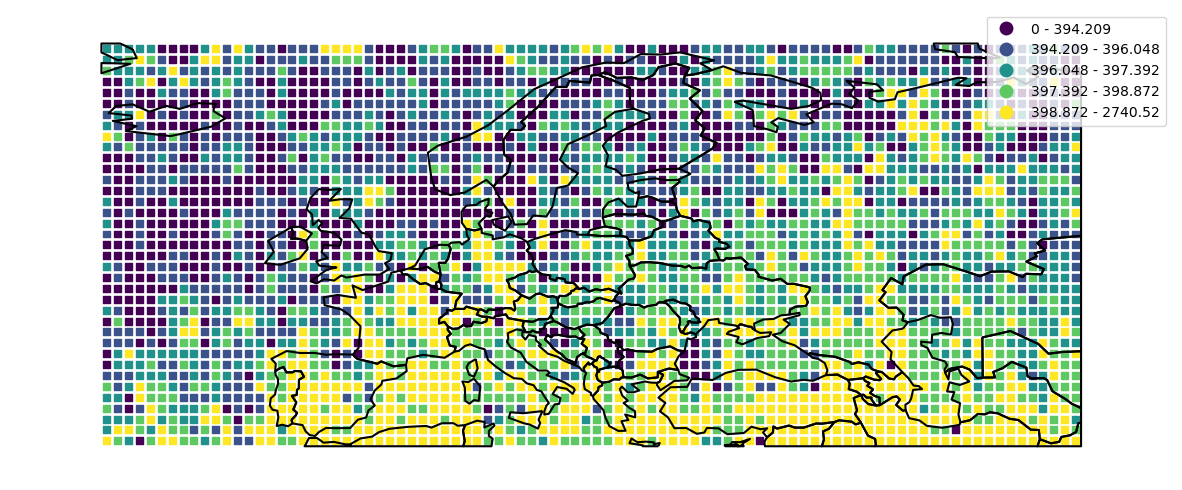

In [ ]:
import mapclassify as mc

scheme = mc.Quantiles(gdf[(gdf.Year == 2016) & (gdf.Month == 8)]['xco2'], k=5)

fig, ax = plt.subplots(figsize = (15,15))

europe.boundary.plot(figsize=(12,8),ax=ax, color='black')
# gplt.pointplot(
#     gdf[(gdf.Year == 2017) & (gdf.Month == 1)],
#     hue='xco2',
#     ax=ax
# )
gplt.pointplot(gdf[(gdf.Year == 2016) & (gdf.Month == 8)], hue='xco2', cmap='viridis', ax=ax, scheme=scheme, legend=True, marker='s')

plt.show()

In [ ]:
aggregate_data.to_csv(Path.cwd()/'data2/clean/oco2_lvl2_xco2_monthly.csv', index=False)